# <span style="color:#4682B4;font-family:Optima;font-size:30pt">Acetylation of Proximal Cysteine-Lysine Pairs by Alcohol Metabolism</span>

Last Update (Script Reproducibility Edit): BG 09/03/2024

# Usage Notes

This analysis was largely inspired by code available from the Mann Lab. Please reference https://github.com/MannLabs/structuremap_analysis/blob/master/data_analysis_structuremap.ipynb for some source code.

Please follow directions in the README to create a virtual environment and run this notebook appropriately.

# Prepare the Environment

In [1]:
!structuremap --version

structuremap, version 0.0.9


In [2]:
from itertools import combinations
import os
import re
import tqdm

import numpy as np
import pandas as pd
import plotly.express as px

import structuremap.utils
from structuremap.processing import (
    download_alphafold_cif, download_alphafold_pae, format_alphafold_data, annotate_accessibility, 
    get_smooth_score, perform_enrichment_analysis, perform_enrichment_analysis_per_protein, 
    annotate_proteins_with_idr_pattern, get_extended_flexible_pattern, get_avg_3d_dist, get_avg_1d_dist, 
    get_proximity_pvals, evaluate_ptm_colocalization
)
from structuremap.plotting import plot_enrichment, plot_ptm_colocalization
structuremap.utils.set_logger()

# Turn off Pandas warnings
pd.options.mode.chained_assignment = None

# Download AlphaFold Data

In [3]:
# Set working directories
wkdir = os.path.dirname(os.path.realpath("__file__"))

# Output dir
output_dir = os.path.join(wkdir, "output")
if not os.path.exists(output_dir):
    os.mkdir(output_dir)
    
# Data dir
data_dir = os.path.join(wkdir, "data")
if not os.path.exists(data_dir):
    os.mkdir(data_dir)

# Make directories
# PAE files
pae_dir = os.path.join(data_dir, "alphafold_predicted_aligned_errors")
if not os.path.exists(pae_dir):
    os.mkdir(pae_dir)
    
# CIF files
cif_dir = os.path.join(data_dir, "alphafold_cifs")
if not os.path.exists(cif_dir):
    os.mkdir(cif_dir)

In [4]:
# Import raw data
ptm_csv_file = os.path.join(data_dir, "231026 Structure Map Cys Lys Peptide Roll-up Combined.csv")
raw_data = pd.read_csv(ptm_csv_file)

# Get uniprot ids
all_uniprot = list(set(raw_data["Accession #"]))
all_uniprot = [uniprot for uniprot in all_uniprot if len(uniprot) == 6]  # Remove invalid formats
print(f"{len(all_uniprot)} unique uniprot IDs found.")

1300 unique uniprot IDs found.


In [5]:
# Download CIF files for uniprot ids
valid_proteins_cif, invalid_proteins_cif, existing_proteins_cif = download_alphafold_cif(
    proteins=all_uniprot,
    out_folder=cif_dir
)

100%|██████████| 1300/1300 [00:54<00:00, 23.88it/s]

2024-09-03 10:51:03> Valid proteins: 0
2024-09-03 10:51:03> Invalid proteins: 19
2024-09-03 10:51:03> Existing proteins: 1281


In [6]:
# Download PAE files for uniprot ids
valid_proteins_pae, invalid_proteins_pae, existing_proteins_pae = download_alphafold_pae(
    proteins=all_uniprot,
    out_folder=pae_dir
)

100%|██████████| 1300/1300 [00:53<00:00, 24.32it/s]

2024-09-03 10:51:57> Valid proteins: 0
2024-09-03 10:51:57> Invalid proteins: 19
2024-09-03 10:51:57> Existing proteins: 1281


In [7]:
# Test if equal protein files available in cif and pae folder
def test_identical_ids(directory_cif, directory_pae):
    """Tests that the C"""
    p_list_cif = list()
    for file in os.listdir(directory_cif):
        if file.endswith('cif'):
            protein_id = re.sub(r'.cif', '', file)
            p_list_cif.append(protein_id)

    p_list_pae = list()
    for file in os.listdir(directory_pae):
        if file.endswith('hdf'):
            protein_id = re.sub(r'.hdf', '', file)
            protein_id = re.sub(r'pae_', '', protein_id)
            p_list_pae.append(protein_id)

    p_list_cif = np.unique(p_list_cif)
    p_list_pae = np.unique(p_list_pae)

    np.testing.assert_equal(len(p_list_cif),len(p_list_pae))
    np.testing.assert_equal(p_list_cif,p_list_pae)

    print('Number of unique proteins with cif and pae file: ',len(p_list_cif))

    
test_identical_ids(f"{cif_dir}/", f"{pae_dir}/")

Number of unique proteins with cif and pae file:  1281


In [8]:
# Output invalid proteins
pd.DataFrame({
    "invalid_proteins": invalid_proteins_cif
}).to_csv(os.path.join(output_dir, "invalid_proteins.csv"), index=False)

# Format AlphaFold Data

In [9]:
all_proteins = valid_proteins_cif + existing_proteins_cif
all_proteins = list(set(all_proteins))
all_proteins.remove("Q9Z2Y8")  # Throws an error for unknown reasons

In [10]:
%%time
alphafold_annotation = format_alphafold_data(directory=cif_dir, protein_ids=all_proteins)

100%|██████████| 1281/1281 [03:11<00:00,  6.67it/s]


CPU times: user 3min 10s, sys: 1.42 s, total: 3min 11s
Wall time: 3min 13s


In [11]:
# Write results to CSV
alphafold_data_dir = os.path.join(data_dir, "alphafold_data")
if not os.path.exists(alphafold_data_dir):
    os.mkdir(alphafold_data_dir)

# alphafold_annotation.to_csv(os.path.join(alphafold_data_dir, "alphafold_annotation.csv"), index=False)
# alphafold_annotation = pd.read_csv(os.path.join(alphafold_data_dir, "alphafold_annotation.csv"))

# Annotate Amino Acid Exposure Metric

### Full Sphere Exposure

In [12]:
%%time
full_sphere_exposure = annotate_accessibility(
    df=alphafold_annotation, 
    max_dist=24, 
    max_angle=180, 
    error_dir=pae_dir
)

  0%|          | 0/1280 [00:00<?, ?it/s]/opt/anaconda3/lib/python3.8/site-packages/structuremap/processing.py:725: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  with h5py.File(os.path.join(
  0%|          | 1/1280 [00:01<31:55,  1.50s/it]/opt/anaconda3/lib/python3.8/site-packages/structuremap/processing.py:725: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  with h5py.File(os.path.join

CPU times: user 35.6 s, sys: 724 ms, total: 36.3 s
Wall time: 38.9 s


In [13]:
# Write results to CSV
# full_sphere_exposure.to_csv(os.path.join(alphafold_data_dir, "full_sphere_exposure.csv"), index=False)
# full_sphere_exposure = pd.read_csv(os.path.join(alphafold_data_dir, "full_sphere_exposure.csv"))

In [14]:
alphafold_accessibility = alphafold_annotation.merge(
    full_sphere_exposure, how='left', on=['protein_id','AA','position']
)

### Half Sphere Exposure

In [15]:
%%time
half_sphere_exposure = annotate_accessibility(
    df=alphafold_annotation, 
    max_dist=12, 
    max_angle=70, 
    error_dir=pae_dir
)

  0%|          | 0/1280 [00:00<?, ?it/s]/opt/anaconda3/lib/python3.8/site-packages/structuremap/processing.py:725: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  with h5py.File(os.path.join(
100%|██████████| 1280/1280 [00:19<00:00, 64.28it/s] 

CPU times: user 16.2 s, sys: 508 ms, total: 16.7 s
Wall time: 20 s


In [16]:
# half_sphere_exposure.to_csv(os.path.join(alphafold_data_dir, "half_sphere_exposure.csv"), index=False)
# half_sphere_exposure = pd.read_csv(os.path.join(alphafold_data_dir, "half_sphere_exposure.csv"))

In [17]:
alphafold_accessibility = alphafold_accessibility.merge(
    half_sphere_exposure, how='left', on=['protein_id','AA','position']
)

In [18]:
alphafold_accessibility['high_acc_5'] = np.where(alphafold_accessibility.nAA_12_70_pae <= 5, 1, 0)
alphafold_accessibility['low_acc_5'] = np.where(alphafold_accessibility.nAA_12_70_pae > 5, 1, 0)

In [19]:
alphafold_accessibility.head(10)

,protein_id,protein_number,AA,position,quality,x_coord_c,x_coord_ca,x_coord_cb,x_coord_n,y_coord_c,...,structure_group,BEND,HELX,STRN,TURN,unstructured,nAA_24_180_pae,nAA_12_70_pae,high_acc_5,low_acc_5
0,A0JNU3,1,M,1,52.21,-3.469,-3.817,-2.641,-4.146,-16.419,...,unstructured,0,0,0,0,1,12,0,1,0
1,A0JNU3,1,A,2,58.54,-3.139,-3.995,-5.341,-4.247,-16.163,...,HELX,0,1,0,0,0,16,0,1,0
2,A0JNU3,1,R,3,73.23,-3.056,-1.807,-0.966,-2.249,-15.832,...,STRN,0,0,1,0,0,43,0,1,0
3,A0JNU3,1,A,4,72.12,-4.387,-4.116,-3.767,-3.019,-15.243,...,HELX,0,1,0,0,0,44,3,1,0
4,A0JNU3,1,M,5,72.90,-6.431,-6.083,-7.280,-5.645,-15.776,...,HELX,0,1,0,0,0,32,0,1,0
5,A0JNU3,1,G,6,78.07,-5.528,-6.729,NaN,-6.350,-15.700,...,BEND,1,0,0,0,0,36,1,1,0
6,A0JNU3,1,P,7,82.21,-4.176,-4.636,-5.199,-5.714,-14.405,...,BEND,1,0,0,0,0,46,0,1,0
7,A0JNU3,1,E,8,90.31,-5.145,-4.750,-5.437,-5.066,-11.241,...,STRN,0,0,1,0,0,75,0,1,0
8,A0JNU3,1,R,9,93.78,-4.232,-4.433,-3.440,-4.236,-8.056,...,STRN,0,0,1,0,0,110,4,1,0
9,A0JNU3,1,R,10,96.27,-5.065,-5.302,-6.597,-5.288,-4.944,...,STRN,0,0,1,0,0,131,2,1,0


In [20]:
alphafold_accessibility.columns

Index(['protein_id', 'protein_number', 'AA', 'position', 'quality',
       'x_coord_c', 'x_coord_ca', 'x_coord_cb', 'x_coord_n', 'y_coord_c',
       'y_coord_ca', 'y_coord_cb', 'y_coord_n', 'z_coord_c', 'z_coord_ca',
       'z_coord_cb', 'z_coord_n', 'secondary_structure', 'structure_group',
       'BEND', 'HELX', 'STRN', 'TURN', 'unstructured', 'nAA_24_180_pae',
       'nAA_12_70_pae', 'high_acc_5', 'low_acc_5'],
      dtype='object')

# Annotate IDRs

In [21]:
alphafold_accessibility_smooth = get_smooth_score(
    alphafold_accessibility, 
    np.array(['quality','nAA_24_180_pae']), 
    [10]
)

100%|██████████| 1280/1280 [00:01<00:00, 1022.93it/s]


In [22]:
alphafold_accessibility_smooth['IDR'] = np.where(
    alphafold_accessibility_smooth['nAA_24_180_pae_smooth10'] <= 34.27, 1, 0
)

# Annotate Short IDRs

In [23]:
alphafold_accessibility_smooth_pattern = annotate_proteins_with_idr_pattern(
    alphafold_accessibility_smooth, 
    min_structured_length = 80, 
    max_unstructured_length = 20
)

100%|██████████| 1280/1280 [00:00<00:00, 1558.29it/s]


In [24]:
alphafold_accessibility_smooth_pattern_ext = get_extended_flexible_pattern(
    alphafold_accessibility_smooth_pattern, 
    ['flexible_pattern'], [5]
)

100%|██████████| 1280/1280 [00:00<00:00, 1290.76it/s]


# Prepare Data for Between PTM Distance Measurements

In [25]:
# Prepare raw data for joining in metadata
ptms = raw_data[
    ['Gene Name', 'Accession #', 'Site', 'p (Corr) ([Ethanol] Vs [Control])', 'FC ([Ethanol] Vs [Control])']
]
ptms.columns = ['protein_name', 'protein_id', 'position', 'p_val', 'fold_change']
ptms['ptm'] = 1
ptms['position'] = ptms.position.astype(str)
ptms['AA'] = ptms['position'].str[0]
ptms['protein_AA_position'] = ptms.protein_id.astype(str) + "_" + ptms.position.astype(str)
ptm_list = list(set(ptms['protein_AA_position']))
ptms.head(10)

,protein_name,protein_id,position,p_val,fold_change,ptm,AA,protein_AA_position
0,Psmc3,O88685,K128,1.626730e-11,-291327.560,1,K,O88685_K128
1,Eef1e1,Q9D1M4,K138,3.804150e-13,-210535.000,1,K,Q9D1M4_K138
2,Gpi,P06745,K366,8.870830e-10,-204922.400,1,K,P06745_K366
3,Nme1,P15532,K124,5.513430e-12,-94431.680,1,K,P15532_K124
4,Elovl5,Q8BHI7,K108,4.156150e-09,-85371.440,1,K,Q8BHI7_K108
5,Xdh,Q00519,K629,3.566140e-09,-72213.470,1,K,Q00519_K629
6,RTRAF,Q9CQE8,K72,1.992250e-12,-64799.457,1,K,Q9CQE8_K72
7,Tpp2,Q64514,K1080,3.913480e-12,-33620.066,1,K,Q64514_K1080
8,Cct2,P80314,K522,6.774370e-13,-26961.865,1,K,P80314_K522
9,Pfkfb1,P70266,K118,2.058890e-12,-16832.094,1,K,P70266_K118


In [26]:
# Assign p-values and fold_change to protein_AA_position
protein_name_dict = {key: value for key, value in zip(ptms['protein_id'], ptms['protein_name'])}
p_val_dict = {key: value for key, value in zip(ptms['protein_AA_position'], ptms['p_val'])}
fold_change_dict = {key: value for key, value in zip(ptms['protein_AA_position'], ptms['fold_change'])}

In [27]:
alphafold_accessibility_smooth_pattern_ext['position'] = alphafold_accessibility_smooth_pattern_ext.position.astype(str)
alphafold_c_and_k = alphafold_accessibility_smooth_pattern_ext[
    (alphafold_accessibility_smooth_pattern_ext["AA"] == "C") | 
    (alphafold_accessibility_smooth_pattern_ext["AA"] == "K")
]
alphafold_c_and_k.head(5)

,protein_id,protein_number,AA,position,quality,x_coord_c,x_coord_ca,x_coord_cb,x_coord_n,y_coord_c,...,unstructured,nAA_24_180_pae,nAA_12_70_pae,high_acc_5,low_acc_5,quality_smooth10,nAA_24_180_pae_smooth10,IDR,flexible_pattern,flexible_pattern_extended_5
39,A0JNU3,1,K,40,94.72,8.580,7.231,6.376,7.322,0.784,...,0,102,3,1,0,94.169524,93.428571,0,0,0
78,A0JNU3,1,C,79,95.76,-1.883,-2.329,-2.106,-1.630,14.186,...,0,120,8,0,1,94.766190,113.285714,0,0,0
134,A0JNU3,1,K,135,95.12,-6.167,-7.464,-8.041,-8.434,-4.411,...,0,151,8,0,1,97.138095,170.476190,0,0,0
172,A0JNU3,1,C,173,98.78,2.193,1.187,1.388,-0.180,0.145,...,0,210,14,0,1,96.782381,169.523810,0,0,0
187,A0JNU3,1,K,188,98.30,12.444,11.256,11.035,10.041,8.110,...,0,160,7,0,1,97.255238,147.000000,0,0,0


<AxesSubplot:>

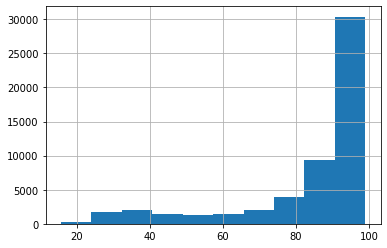

In [28]:
alphafold_c_and_k['quality'].hist()

# 3D Distance Between PTMs

This is custom code to generate the final data set we can use for downstream analysis.

In [29]:
# Function adapted from https://github.com/MannLabs/structuremap/blob/main/structuremap/processing.py#L320
def get_3d_dist(
    coordinate_array_1: np.ndarray,
    coordinate_array_2: np.ndarray
) -> float:
    """
    Function to get the distance between two coordinates in 3D space.
    Input are two coordinate arrays and two respective indices that specify
    for which points in the coordinate arrays the distance should be calculated.

    Parameters
    ----------
    coordinate_array_1 : np.ndarray
        Array of 3D coordinates.
        Must be 3d, e.g. np.float64[:,3]
    coordinate_array_2 : np.ndarray
        Array of 3D coordinates.
        Must be 3d, e.g. np.float64[:,3]
    idx_1 : int
        Integer to select an index in coordinate_array_1.
    idx_2 : int
        Integer to select an index in coordinate_array_2.

    Returns
    -------
    : float
        Distance between the two selected 3D coordinates.
    """
    dist = np.sqrt(
        (coordinate_array_1[0] - coordinate_array_2[0])**2 + 
        (coordinate_array_1[1] - coordinate_array_2[1])**2 + 
        (coordinate_array_1[2] - coordinate_array_2[2])**2
    )
    
    return(dist)


# Target Data Set Generation

In [30]:
# Get protein_ids and ptms to loop through
proteins_of_interest = list(set(alphafold_c_and_k.protein_id))

# Empty data frame to store all pairwise distances
all_pairwise_distances_df = pd.DataFrame()

# Loop through all proteins
for i, prot_of_interest in enumerate(proteins_of_interest, 1):
    print(f"Protein {prot_of_interest} ({i}/{len(proteins_of_interest)})...")
    
    # Subset the data frame by protein and extract PTMs of interest
    protein_df = alphafold_c_and_k[(alphafold_c_and_k.protein_id == prot_of_interest)]
    protein_df["AA_position"] = protein_df.AA + protein_df.position

    # Get the combinations of PTMs to measure between-PTM distances
    # Example: Three sites of K66, K70, K99 would become [(K66, K70), (K66, K99), (K70, K99)]
    pairwise_combinations = list(set(combinations(protein_df.AA_position, 2)))

    # Empty data frame to store protein-ptm-specific distances
    for aa_pair in pairwise_combinations:
        #print(aa_pair)

        # Get proteins to calculate distance between
        aa1, aa2 = sorted(aa_pair) # Sorting to consistently get C-K (and no K-C)
        
        # Looking for K-to-C or C-to-K distances (index [0] is looking for AA type)
        if aa1[0] != aa2[0]:
            # Get protein1 3D coordinates
            c_df = protein_df[protein_df['AA_position'] == aa1]
            c_coords = c_df[["x_coord_ca", "y_coord_ca", "z_coord_ca"]].to_numpy()[0]

            # Get protein2 3D coordinates
            k_df = protein_df[protein_df['AA_position'] == aa2]
            k_coords = k_df[["x_coord_ca", "y_coord_ca", "z_coord_ca"]].to_numpy()[0]

            # Calculate 3D distance
            dist_3d = get_3d_dist(c_coords, k_coords)
            
            # Determine if either AA is a PTM
            c_id = f"{prot_of_interest}_{aa1}"
            c_ptm = 1 if c_id in ptm_list else 0
            k_id = f"{prot_of_interest}_{aa2}"
            k_ptm = 1 if k_id in ptm_list else 0
            
            # Determine PTM grouping
            # Group 0: 0 PTMS
            # Group 1: C PTM = 0, K PTM = 1
            # Group 1: C PTM = 1, K PTM = 0
            # Group 3: Both PTMs
            ptm_grouping = 0
            if (c_ptm == 0) & (k_ptm == 0):
                ptm_grouping = 0
            elif (c_ptm == 0) & (k_ptm == 1):
                ptm_grouping = 1
            elif (c_ptm == 1) & (k_ptm == 0):
                ptm_grouping = 2
            elif (c_ptm == 1) & (k_ptm == 1):
                ptm_grouping = 3
            
            # Get p-value and fold-change of ptms
            # Cystines
            c_p_val = np.nan
            c_fold_change = np.nan
            if c_ptm:
                c_p_val = p_val_dict[f"{prot_of_interest}_{aa1}"]
                c_fold_change = fold_change_dict[f"{prot_of_interest}_{aa1}"]
            
            # Lysines
            k_p_val = np.nan
            k_fold_change = np.nan
            if k_ptm:
                k_p_val = p_val_dict[f"{prot_of_interest}_{aa2}"]
                k_fold_change = fold_change_dict[f"{prot_of_interest}_{aa2}"]
            
            # Format results in df
            distance_results = pd.DataFrame({
                "gene_name": [protein_name_dict[prot_of_interest]],
                "accession_num": [prot_of_interest],
                "c_position": [aa1],
                "c_ptm": [c_ptm],
                "c_p_val": [c_p_val],
                "c_fold_change": [c_fold_change],
                "c_quality_score": [float(c_df.quality)],
                "c_x_coord": [float(c_df.x_coord_ca)],
                "c_y_coord": [float(c_df.y_coord_ca)],
                "c_z_coord": [float(c_df.z_coord_ca)],
                "c_nAA_24_180_pae": [int(c_df.nAA_24_180_pae)], 
                "c_nAA_12_70_pae": [int(c_df.nAA_12_70_pae)], 
                "k_position": [aa2],
                "k_ptm": [k_ptm],
                "k_p_val": [k_p_val],
                "k_fold_change": [k_fold_change],
                "k_quality_score": [float(k_df.quality)],
                "k_x_coord": [float(k_df.x_coord_ca)],
                "k_y_coord": [float(k_df.y_coord_ca)],
                "k_z_coord": [float(k_df.z_coord_ca)],
                "k_nAA_24_180_pae": [int(k_df.nAA_24_180_pae)], 
                "k_nAA_12_70_pae": [int(k_df.nAA_12_70_pae)],
                "ptm_grouping": [ptm_grouping],
                "total_ptms": [c_ptm + k_ptm],
                "dist_3d": [round(dist_3d, 3)]
            })

            # Append results
            all_pairwise_distances_df = pd.concat([all_pairwise_distances_df, distance_results])
            

Protein Q9D906 (1/1280)...
Protein Q8JZK9 (2/1280)...
Protein Q9CRA7 (3/1280)...
Protein Q80W22 (4/1280)...
Protein Q6PDG5 (5/1280)...
Protein P01942 (6/1280)...
Protein O55142 (7/1280)...
Protein P97807 (8/1280)...
Protein Q99JY0 (9/1280)...
Protein P17717 (10/1280)...
Protein Q8R3D1 (11/1280)...
Protein Q99J99 (12/1280)...
Protein Q9WU19 (13/1280)...
Protein O35490 (14/1280)...
Protein Q6Q6R3 (15/1280)...
Protein Q9DBW0 (16/1280)...
Protein Q9WVM8 (17/1280)...
Protein P49138 (18/1280)...
Protein P05202 (19/1280)...
Protein P28271 (20/1280)...
Protein P19639 (21/1280)...
Protein Q02780 (22/1280)...
Protein Q9DCT2 (23/1280)...
Protein O09167 (24/1280)...
Protein Q9D110 (25/1280)...
Protein Q9CQ62 (26/1280)...
Protein Q9WVD5 (27/1280)...
Protein Q8BGH2 (28/1280)...
Protein P19096 (29/1280)...
Protein Q9CRC0 (30/1280)...
Protein Q8BP67 (31/1280)...
Protein Q9CXW4 (32/1280)...
Protein P98192 (33/1280)...
Protein Q9JII6 (34/1280)...
Protein Q8R081 (35/1280)...
Protein Q9Z0N1 (36/1280)...
P

Protein Q8CCG1 (288/1280)...
Protein O35459 (289/1280)...
Protein P56593 (290/1280)...
Protein Q9DBG6 (291/1280)...
Protein Q61598 (292/1280)...
Protein Q99J08 (293/1280)...
Protein Q9CQV8 (294/1280)...
Protein P15532 (295/1280)...
Protein P17095 (296/1280)...
Protein Q9JIX8 (297/1280)...
Protein Q68FD5 (298/1280)...
Protein Q99N94 (299/1280)...
Protein P62983 (300/1280)...
Protein P12787 (301/1280)...
Protein Q99MR8 (302/1280)...
Protein Q9CQP0 (303/1280)...
Protein A2AIL4 (304/1280)...
Protein Q9DBG1 (305/1280)...
Protein Q8BGQ7 (306/1280)...
Protein P97823 (307/1280)...
Protein Q7TQK4 (308/1280)...
Protein Q9CXJ4 (309/1280)...
Protein Q9D0F3 (310/1280)...
Protein Q9R0P5 (311/1280)...
Protein P29699 (312/1280)...
Protein Q9QXE0 (313/1280)...
Protein Q920A7 (314/1280)...
Protein Q8BG17 (315/1280)...
Protein Q61578 (316/1280)...
Protein P20108 (317/1280)...
Protein Q9CQ19 (318/1280)...
Protein Q05920 (319/1280)...
Protein Q06185 (320/1280)...
Protein Q9QYR9 (321/1280)...
Protein E9Q5C9

Protein P08228 (571/1280)...
Protein Q8K2I4 (572/1280)...
Protein Q8BZW8 (573/1280)...
Protein Q8R2L5 (574/1280)...
Protein Q9EQ06 (575/1280)...
Protein Q8CEE7 (576/1280)...
Protein P11862 (577/1280)...
Protein P08113 (578/1280)...
Protein Q8VCR7 (579/1280)...
Protein O08600 (580/1280)...
Protein P40124 (581/1280)...
Protein Q8BFW4 (582/1280)...
Protein Q8BGD9 (583/1280)...
Protein Q91VM9 (584/1280)...
Protein Q91VD9 (585/1280)...
Protein P14428 (586/1280)...
Protein P68254 (587/1280)...
Protein P27659 (588/1280)...
Protein Q91VE0 (589/1280)...
Protein P14148 (590/1280)...
Protein Q9WTX5 (591/1280)...
Protein Q925N0 (592/1280)...
Protein Q64516 (593/1280)...
Protein P47911 (594/1280)...
Protein P62880 (595/1280)...
Protein Q9QYJ0 (596/1280)...
Protein Q5BL07 (597/1280)...
Protein O55022 (598/1280)...
Protein P39087 (599/1280)...
Protein Q9QX47 (600/1280)...
Protein Q924M7 (601/1280)...
Protein Q91XD4 (602/1280)...
Protein Q9D8W7 (603/1280)...
Protein Q8VI36 (604/1280)...
Protein Q9JJL8

Protein Q9QZX7 (854/1280)...
Protein Q8K1Z0 (855/1280)...
Protein Q3UEG6 (856/1280)...
Protein Q6PDI5 (857/1280)...
Protein Q99N85 (858/1280)...
Protein P51660 (859/1280)...
Protein P68372 (860/1280)...
Protein Q91WN4 (861/1280)...
Protein Q8R050 (862/1280)...
Protein Q8BYL4 (863/1280)...
Protein Q8BH86 (864/1280)...
Protein Q9DBE0 (865/1280)...
Protein P53395 (866/1280)...
Protein Q80Y14 (867/1280)...
Protein P57780 (868/1280)...
Protein Q9WU78 (869/1280)...
Protein Q9CPP6 (870/1280)...
Protein Q80XN0 (871/1280)...
Protein P63030 (872/1280)...
Protein P47857 (873/1280)...
Protein P35486 (874/1280)...
Protein Q8BTY1 (875/1280)...
Protein Q8K2V1 (876/1280)...
Protein Q9DCX2 (877/1280)...
Protein Q8VC12 (878/1280)...
Protein Q9ERK4 (879/1280)...
Protein B1AR13 (880/1280)...
Protein Q8BP40 (881/1280)...
Protein Q9DC61 (882/1280)...
Protein Q9JKV1 (883/1280)...
Protein E9Q816 (884/1280)...
Protein Q9CQE1 (885/1280)...
Protein Q8C2Q3 (886/1280)...
Protein Q8QZT1 (887/1280)...
Protein P19536

Protein Q91WS0 (1132/1280)...
Protein P54071 (1133/1280)...
Protein O55143 (1134/1280)...
Protein P14206 (1135/1280)...
Protein Q9WUM5 (1136/1280)...
Protein P05063 (1137/1280)...
Protein Q91VR5 (1138/1280)...
Protein Q91V16 (1139/1280)...
Protein P20852 (1140/1280)...
Protein Q60864 (1141/1280)...
Protein Q99LC3 (1142/1280)...
Protein Q91ZW3 (1143/1280)...
Protein P58281 (1144/1280)...
Protein Q60866 (1145/1280)...
Protein Q8BMG8 (1146/1280)...
Protein Q922D4 (1147/1280)...
Protein A2AKK5 (1148/1280)...
Protein Q8JZU2 (1149/1280)...
Protein P56657 (1150/1280)...
Protein Q920L1 (1151/1280)...
Protein Q3TL44 (1152/1280)...
Protein Q9D7S9 (1153/1280)...
Protein Q8R3L2 (1154/1280)...
Protein Q99K28 (1155/1280)...
Protein Q99KK9 (1156/1280)...
Protein Q9CXD6 (1157/1280)...
Protein Q7TMC8 (1158/1280)...
Protein O35945 (1159/1280)...
Protein A6H8H2 (1160/1280)...
Protein Q6PER3 (1161/1280)...
Protein Q9CWE0 (1162/1280)...
Protein P46471 (1163/1280)...
Protein Q8VCB3 (1164/1280)...
Protein Q9

In [31]:
# Output distance measures
all_pairwise_distances_df = all_pairwise_distances_df.drop_duplicates()
all_pairwise_distances_df.to_csv(
    os.path.join(output_dir, f"{pd.Timestamp.now().strftime('%Y%m%d')}_ptm_pairwise_distances.csv"), index=False
)